# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [95]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [96]:
# load in the data
azdias = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

c:\program files\python3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [97]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [98]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [99]:
set(azdias.columns)-set(customers.columns)

set()

In [100]:
set(customers.columns)-set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

The customers table has three more fields.

In [101]:
# drop these three features
my_customers=customers.drop(labels=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis=1)

In [102]:
DIAS_attributes= pd.read_excel("DIAS Attributes - Values 2017.xlsx")

In [103]:
DIAS_attributes.shape

(2258, 5)

In [104]:
 DIAS_info=pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx")

In [105]:
# Mark nan from the azdias data
DIAS_attributes.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [106]:
DIAS_attributes.drop(['Unnamed: 0'],axis=1,inplace=True)

In [107]:
if 'Attribute' in DIAS_attributes.iloc[0][0]:
    DIAS_attributes.drop(index=[0],axis=0,inplace=True)

In [108]:
DIAS_attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [109]:
DIAS_attributes.columns = ['Attribute','Description','Value','Meaning']

In [110]:
attribute_name=''
# description_name=''
for i,v in DIAS_attributes.iterrows():
    if v['Attribute'] is np.nan:
        v['Attribute']=attribute_name
    else:
        attribute_name=v['Attribute']
#     if v['Description'] is np.nan:
#         v['Description']=description_name
#     else:
#         description_name=v['Description']

In [111]:
DIAS_attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [112]:
missing_attribute_value_list=[]
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'unknown' in v['Meaning']:
            missing_attribute_value_list.append([v['Attribute'],v['Value'],v['Meaning']])

In [113]:
numerical_attribute=set()
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'numeric' in v['Meaning']:
            numerical_attribute.add(v['Attribute'])

In [114]:
print(numerical_attribute)

{'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBURTSJAHR', 'ANZ_PERSONEN', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR', 'ANZ_TITEL'}


In [115]:
DIAS_attributes_name=set(DIAS_attributes['Attribute'].drop_duplicates())
DIAS_attributes_name-set(azdias.columns)

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

- None of the above attributes mentioned

In [116]:
set(azdias.columns)-DIAS_attributes_name

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSICHERUNGEN',
 '

- Lack of description of the above attributes

In [117]:
print(azdias['LNR'].duplicated().sum(),customers['LNR'].duplicated().sum())
print(set(azdias['LNR'])&set(customers['LNR']))

0 0
set()


In [118]:
def unknown2missing(df):
    df_temp=df.copy()
    for l in missing_attribute_value_list:
        if l[0] in df.columns:
            if isinstance(l[1],int):
                df_temp[l[0]]=df[l[0]].replace(l[1],np.nan)
            else:
                for ll in l[1].split(','):
                    df_temp[l[0]]=df[l[0]].replace(int(ll),np.nan)
    return df_temp
        

- LNR was unique so that I will set it as index.

In [119]:
my_azdias=unknown2missing(azdias)
print(azdias.isnull().mean().mean())
print(my_azdias.isnull().mean().mean())

0.10268016415595567
0.11370020865890973


In [120]:
my_customers=unknown2missing(customers)
print(customers.isnull().mean().mean())
print(my_customers.isnull().mean().mean())

0.1960492473457283
0.20487207872308308


In [121]:
def azdias_customers_plot(column):
    fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)
    sns.countplot(x = column, data=azdias, ax=ax1, palette="Set3")
    ax1.set_xlabel('Value')
    ax1.set_title('AZDIAS '+column+' feature')
    sns.countplot(x = column, data=customers, ax=ax2, palette="Set3")
    ax2.set_xlabel('Value')
    ax2.set_title('CUSTOMERS '+column+' feature')
    fig.tight_layout()
    plt.show()

In [122]:
import random

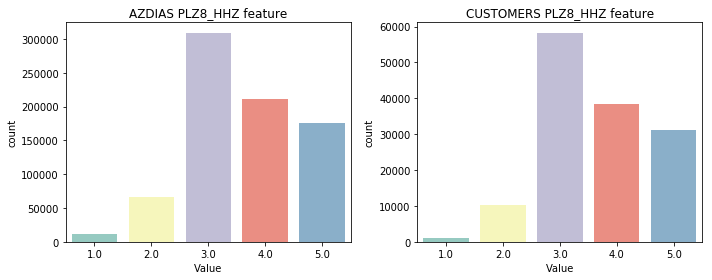

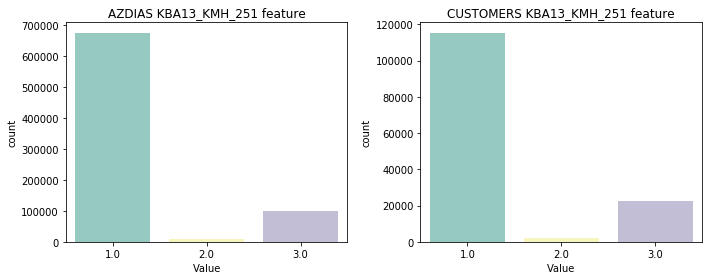

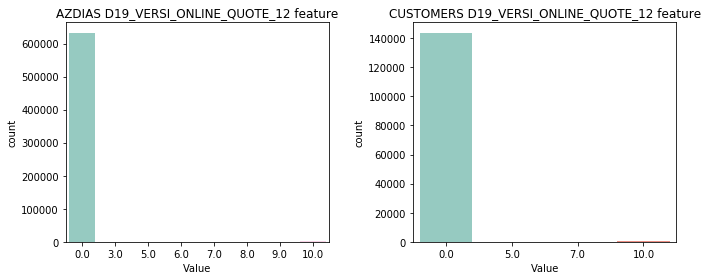

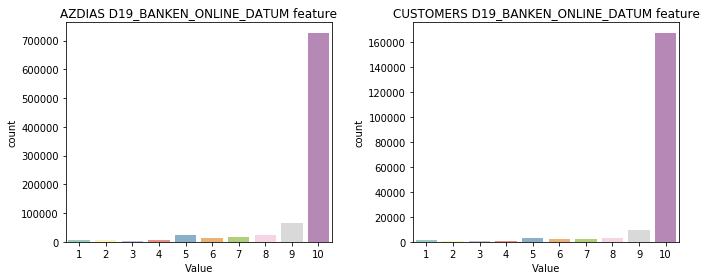

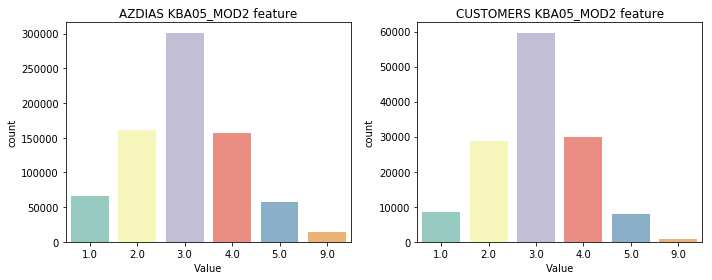

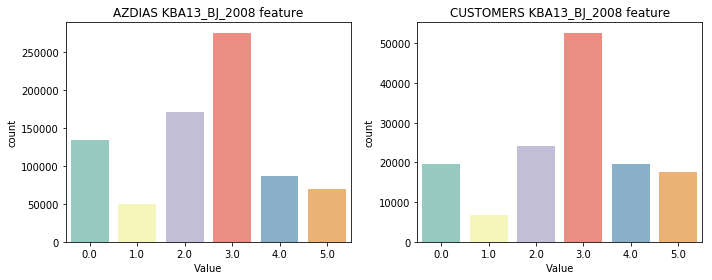

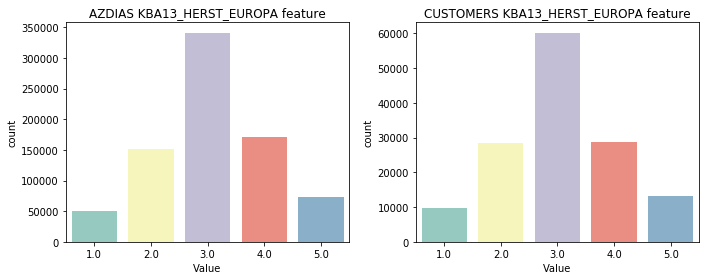

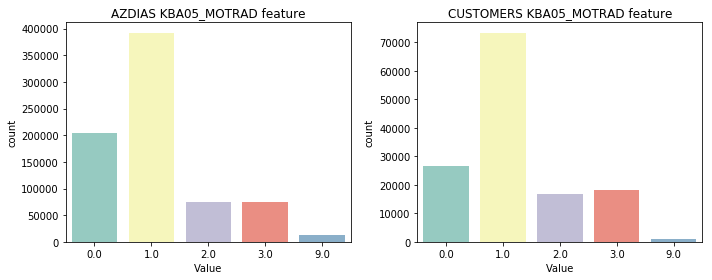

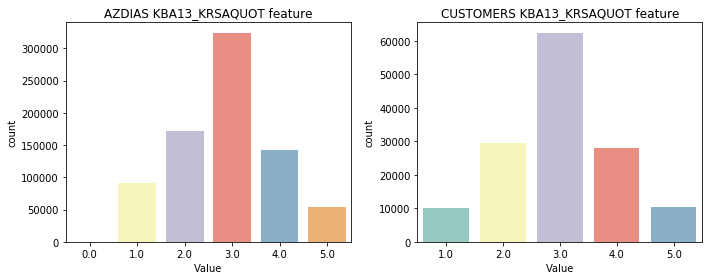

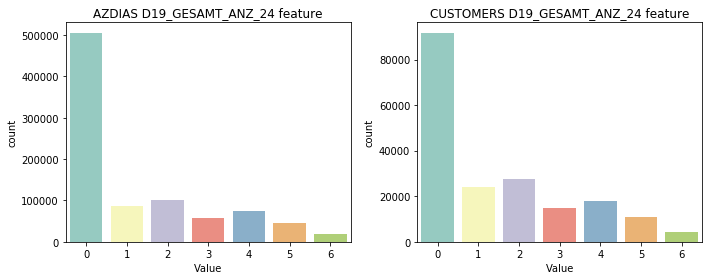

In [123]:
for i in random.sample(range(0,len(azdias.columns)-1),10):
    azdias_customers_plot(azdias.columns[i])

- From the random distribution map, the two data sets are distributed and similar

### 1.Deal with the numerical features

In [124]:
drop_features=set()

In [125]:
# in numerical_attribute_value_list: 
# {'MIN_GEBAEUDEJAHR', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_TITEL', 'ANZ_PERSONEN', 'GEBURTSJAHR', 'ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW'}
my_azdias['MIN_GEBAEUDEJAHR'].value_counts()

1992.0    568776
1994.0     78835
1993.0     25488
1995.0     25464
1996.0     16611
1997.0     14464
2000.0      7382
2001.0      5877
1991.0      5811
2005.0      5553
1999.0      4413
1990.0      4408
2002.0      4216
1998.0      4097
2003.0      3356
2004.0      2935
2008.0      2197
2007.0      2156
1989.0      2046
2009.0      2016
2006.0      1984
2011.0      1903
2012.0      1861
2010.0      1410
2013.0      1230
1988.0      1027
2014.0      1001
2015.0       717
1987.0       470
2016.0       128
1986.0       125
1985.0       116
Name: MIN_GEBAEUDEJAHR, dtype: int64

- 'MIN_GEBAEUDEJAHR' will be replaced by age.

In [126]:
print(my_azdias['ANZ_HAUSHALTE_AKTIV'].value_counts())

1.0      195957
2.0      120982
3.0       62575
4.0       43213
5.0       37815
6.0       36020
7.0       34526
8.0       32293
9.0       29002
10.0      25428
11.0      21965
12.0      18033
13.0      15282
14.0      12625
15.0      10371
16.0       8899
17.0       7292
0.0        6463
18.0       6324
19.0       5461
20.0       4674
21.0       4138
22.0       3735
23.0       3243
24.0       2838
25.0       2636
26.0       2342
27.0       2232
28.0       2040
29.0       1963
          ...  
285.0         4
515.0         4
523.0         4
301.0         4
249.0         4
174.0         4
266.0         4
256.0         4
255.0         4
250.0         4
260.0         4
331.0         4
226.0         3
224.0         3
168.0         3
307.0         3
414.0         3
244.0         3
378.0         3
293.0         3
272.0         3
395.0         3
237.0         2
254.0         2
404.0         2
213.0         2
366.0         1
536.0         1
232.0         1
220.0         1
Name: ANZ_HAUSHALTE_AKTI

In [127]:
#  'ANZ_HAUSHALTE_AKTIV', 'ANZ_TITEL', 'ANZ_PERSONEN', 'GEBURTSJAHR','KBA13_ANZAHL_PKW'
my_azdias['ANZ_TITEL'].value_counts()

0.0    814542
1.0      2970
2.0       202
3.0         5
4.0         2
6.0         1
Name: ANZ_TITEL, dtype: int64

In [128]:
my_azdias['ANZ_PERSONEN'].value_counts()

1.0     423383
2.0     195470
3.0      94905
4.0      47126
0.0      34103
5.0      15503
6.0       4842
7.0       1525
8.0        523
9.0        180
10.0        67
11.0        38
12.0        16
13.0        11
21.0         4
14.0         4
20.0         3
15.0         3
38.0         2
23.0         2
37.0         2
22.0         2
35.0         1
17.0         1
16.0         1
45.0         1
18.0         1
40.0         1
29.0         1
31.0         1
Name: ANZ_PERSONEN, dtype: int64

In [129]:
my_azdias['GEBURTSJAHR'].value_counts()

0       392318
1967     11183
1965     11090
1966     10933
1970     10883
1964     10799
1968     10792
1963     10513
1969     10360
1980     10275
1962     10082
1961      9880
1971      9786
1982      9516
1978      9509
1960      9492
1979      9422
1981      9374
1977      9296
1959      9098
1972      9027
1976      9005
1983      8887
1974      8676
1984      8553
1975      8480
1973      8356
1958      8323
1986      8192
1985      8180
         ...  
2009       559
2008       550
2010       545
2011       485
1923       468
2013       380
1922       375
1921       355
2015       257
1920       238
1919       194
2016       167
2014       124
1918        85
1914        55
1917        55
1916        45
1910        41
1913        39
1915        37
1911        30
1912        28
1905         8
1908         7
1906         7
1909         7
1904         5
1907         4
1900         4
1902         1
Name: GEBURTSJAHR, Length: 117, dtype: int64

- 'GEBURTSJAHR' will be replaced by age.

In [130]:
my_azdias['KBA13_ANZAHL_PKW'].value_counts()

1400.0    11722
1500.0     8291
1300.0     6427
1600.0     6135
1700.0     3795
1800.0     2617
464.0      1604
417.0      1604
519.0      1600
534.0      1496
386.0      1458
1900.0     1450
395.0      1446
481.0      1417
455.0      1409
483.0      1393
452.0      1388
418.0      1384
454.0      1380
450.0      1380
494.0      1379
459.0      1379
492.0      1359
504.0      1340
387.0      1338
420.0      1337
439.0      1327
506.0      1326
388.0      1324
456.0      1323
          ...  
28.0         24
27.0         24
25.0         23
24.0         22
26.0         21
18.0         21
17.0         20
20.0         18
21.0         17
22.0         16
12.0         16
14.0         16
29.0         15
15.0         14
23.0         13
30.0         12
16.0         11
19.0         11
13.0         10
1.0           8
10.0          8
11.0          7
5.0           7
9.0           7
4.0           7
3.0           6
8.0           6
2.0           6
7.0           5
6.0           5
Name: KBA13_ANZAHL_PKW, 

In [131]:
numerical_attribute

{'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR'}

In [132]:
DIAS_attributes['Attribute'].value_counts()

CAMEO_DEU_2015                 44
LP_LEBENSPHASE_FEIN            40
CAMEO_DEUINTL_2015             26
ALTER_HH                       22
PRAEGENDE_JUGENDJAHRE          16
GFK_URLAUBERTYP                12
LP_LEBENSPHASE_GROB            12
D19_BANKEN_ONLINE_QUOTE_12     11
LP_FAMILIE_GROB                11
D19_VERSAND_ONLINE_QUOTE_12    11
LP_FAMILIE_FEIN                11
D19_GESAMT_ONLINE_QUOTE_12     11
D19_VERSAND_ONLINE_DATUM       10
D19_GESAMT_DATUM               10
D19_GESAMT_OFFLINE_DATUM       10
D19_BANKEN_ONLINE_DATUM        10
D19_GESAMT_ONLINE_DATUM        10
D19_TELKO_OFFLINE_DATUM        10
LP_STATUS_GROB                 10
D19_VERSAND_DATUM              10
D19_TELKO_ONLINE_DATUM         10
LP_STATUS_FEIN                 10
D19_BANKEN_DATUM               10
ORTSGR_KLS9                    10
WOHNDAUER_2008                 10
D19_BANKEN_OFFLINE_DATUM       10
CAMEO_DEUG_2015                10
HAUSHALTSSTRUKTUR              10
D19_VERSAND_OFFLINE_DATUM      10
D19_TELKO_DATU

- I think the numeric features have only 1 or 2 values meaning.

In [133]:
attribute_value_number=[]
for i in my_azdias.columns:
    attribute_value_number.append((len(my_azdias[i].value_counts()),i))

In [134]:
print(sorted(attribute_value_number))

[(2, 'ANREDE_KZ'), (2, 'DSL_FLAG'), (2, 'GREEN_AVANTGARDE'), (2, 'HH_DELTA_FLAG'), (2, 'KBA05_SEG6'), (2, 'KONSUMZELLE'), (2, 'OST_WEST_KZ'), (2, 'SOHO_KZ'), (2, 'UNGLEICHENN_FLAG'), (2, 'VERS_TYP'), (3, 'HEALTH_TYP'), (3, 'KBA05_ANTG4'), (3, 'KBA05_KRSKLEIN'), (3, 'KBA05_KRSOBER'), (3, 'KBA05_KRSVAN'), (3, 'KBA05_KRSZUL'), (3, 'KBA05_MAXVORB'), (3, 'KBA13_ANTG4'), (3, 'KBA13_KMH_110'), (3, 'KBA13_KMH_251'), (3, 'KBA13_KW_30'), (3, 'NATIONALITAET_KZ'), (3, 'PLZ8_ANTG4'), (3, 'STRUKTURTYP'), (4, 'AGER_TYP'), (4, 'KBA05_ANHANG'), (4, 'KBA05_ANTG3'), (4, 'KBA05_MAXBJ'), (4, 'KBA05_MAXSEG'), (4, 'KBA05_MOD8'), (4, 'KBA05_MOTOR'), (4, 'KBA05_MOTRAD'), (4, 'KBA05_SEG1'), (4, 'KBA05_SEG7'), (4, 'KBA05_SEG8'), (4, 'KBA05_SEG9'), (4, 'KBA13_ANTG3'), (4, 'KBA13_KRSSEG_KLEIN'), (4, 'KBA13_KRSSEG_OBER'), (4, 'KBA13_KRSSEG_VAN'), (4, 'KBA13_KRSZUL_NEU'), (4, 'KBA13_MOTOR'), (4, 'KKK'), (4, 'PLZ8_ANTG3'), (4, 'SHOPPER_TYP'), (5, 'ALTERSKATEGORIE_GROB'), (5, 'CJT_KATALOGNUTZER'), (5, 'CJT_TYP_1'), (5

- numerical feature might have more value,so I will check the value count bigger than 30

In [135]:
[x for x in attribute_value_number if x[0]>30]

[(891221, 'LNR'),
 (292, 'ANZ_HAUSHALTE_AKTIV'),
 (268, 'ANZ_STATISTISCHE_HAUSHALTE'),
 (45, 'CAMEO_DEU_2015'),
 (43, 'CAMEO_INTL_2015'),
 (35, 'D19_LETZTER_KAUF_BRANCHE'),
 (5162, 'EINGEFUEGT_AM'),
 (37, 'EINGEZOGENAM_HH_JAHR'),
 (56, 'EXTSEL992'),
 (117, 'GEBURTSJAHR'),
 (1261, 'KBA13_ANZAHL_PKW'),
 (41, 'LP_LEBENSPHASE_FEIN'),
 (32, 'MIN_GEBAEUDEJAHR'),
 (46, 'VERDICHTUNGSRAUM')]

In [136]:
set([x[1] for x in attribute_value_number if x[0]>30])-numerical_attribute-drop_features-set(['LNR'])

{'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'LP_LEBENSPHASE_FEIN',
 'VERDICHTUNGSRAUM'}

- LNR will be the index,
- EINGEFUEGT_AM,D19_LETZTER_KAUF_BRANCHE,EINGEZOGENAM_HH_JAHR I don't know what is it.

In [137]:
drop_features=drop_features|set(['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE','EINGEZOGENAM_HH_JAHR'])
my_azdias['ANZ_STATISTISCHE_HAUSHALTE'].value_counts()

1.0      219119
2.0      121485
3.0       61478
4.0       44864
5.0       40133
6.0       38466
7.0       36589
8.0       32816
9.0       28500
10.0      24100
11.0      19461
12.0      16296
13.0      13040
14.0      10616
15.0       8939
16.0       7314
17.0       6136
18.0       5220
19.0       4465
20.0       3840
21.0       3433
22.0       3221
23.0       2633
24.0       2485
25.0       2384
26.0       2042
27.0       1995
28.0       1930
29.0       1712
30.0       1661
          ...  
258.0         5
228.0         5
177.0         5
242.0         5
218.0         4
216.0         4
239.0         4
203.0         4
241.0         4
209.0         4
262.0         4
198.0         4
284.0         4
309.0         4
245.0         3
182.0         3
248.0         3
229.0         3
371.0         3
289.0         3
449.0         3
175.0         2
165.0         2
227.0         2
189.0         2
190.0         2
336.0         2
197.0         2
133.0         1
314.0         1
Name: ANZ_STATISTISCHE_H

- I think it's a numerical feature. 

In [138]:
numerical_attribute.add('ANZ_STATISTISCHE_HAUSHALTE')

In [139]:
my_azdias['EXTSEL992'].value_counts()

56.0    19722
31.0    14987
27.0    13269
38.0    12856
23.0    12742
36.0    12059
35.0    11308
55.0     9812
34.0     8583
50.0     6435
53.0     5686
37.0     5211
21.0     5114
54.0     4857
6.0      4815
41.0     4517
19.0     4445
29.0     4332
18.0     4315
39.0     4253
33.0     4199
25.0     4095
20.0     4069
26.0     3087
32.0     3041
15.0     2917
48.0     2916
17.0     2868
14.0     2832
40.0     2787
3.0      2783
2.0      2701
43.0     2602
46.0     2550
22.0     2244
24.0     2238
47.0     1659
1.0      1526
4.0      1468
13.0     1458
30.0     1457
5.0      1437
52.0     1415
16.0     1147
45.0     1087
12.0     1027
9.0       983
42.0      912
10.0      866
11.0      709
51.0      674
8.0       642
7.0       546
44.0      447
49.0      251
28.0      110
Name: EXTSEL992, dtype: int64

- I think it's a numerical feature.

In [140]:
numerical_attribute.add('EXTSEL992')

In [141]:
my_azdias['VERDICHTUNGSRAUM'].value_counts()

0.0     368782
1.0     111235
2.0      47613
3.0      29827
4.0      26996
5.0      24019
6.0      21882
7.0      13238
8.0      11864
10.0     11034
9.0       9425
13.0      8707
11.0      8226
14.0      8180
12.0      8046
15.0      6942
16.0      6435
17.0      5502
18.0      5061
20.0      3538
22.0      3492
21.0      3364
19.0      3300
23.0      3239
24.0      2980
25.0      2887
30.0      2648
27.0      2622
26.0      2569
29.0      2552
28.0      2454
32.0      2390
31.0      2313
33.0      2240
34.0      2054
36.0      1959
35.0      1769
39.0      1660
38.0      1622
44.0      1435
40.0      1359
37.0      1348
41.0      1329
42.0      1324
43.0      1321
45.0      1165
Name: VERDICHTUNGSRAUM, dtype: int64

- I think it's a numerical feature.

In [142]:
numerical_attribute.add('VERDICHTUNGSRAUM')

In [143]:
print(drop_features)

{'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'D19_LETZTER_KAUF_BRANCHE'}


In [144]:
set([x[1] for x in attribute_value_number if x[0]>30])-numerical_attribute-drop_features-set(['LNR'])

{'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN'}

In [145]:
print(my_azdias['CAMEO_DEU_2015'].value_counts(),my_azdias['CAMEO_INTL_2015'].value_counts(),my_azdias['LP_LEBENSPHASE_FEIN'].value_counts())

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64 51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0 

In [146]:
print(numerical_attribute)

{'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'VERDICHTUNGSRAUM', 'ANZ_STATISTISCHE_HAUSHALTE', 'GEBURTSJAHR', 'EXTSEL992', 'ANZ_PERSONEN', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR', 'ANZ_TITEL'}


- That's all,I accept the result of numerical features.

### 2.Deal with the categories features

In [147]:
categories_attribute=set(my_azdias.columns)-numerical_attribute-drop_features-set(['LNR'])

In [148]:
my_azdias_categories=my_azdias[list(categories_attribute)]

In [149]:
my_azdias_categories.columns.to_series().groupby(my_azdias_categories.dtypes).groups

{dtype('int64'): Index(['D19_GESAMT_DATUM', 'D19_GESAMT_ANZ_12', 'D19_VERSI_ANZ_12',
        'SEMIO_REL', 'FINANZ_MINIMALIST', 'D19_BEKLEIDUNG_REST',
        'D19_TELKO_REST', 'D19_BILDUNG', 'ZABEOTYP', 'D19_ENERGIE',
        'D19_BANKEN_REST', 'D19_TECHNIK', 'D19_LEBENSMITTEL', 'ANREDE_KZ',
        'D19_VERSAND_OFFLINE_DATUM', 'SEMIO_TRADV', 'FINANZ_ANLEGER',
        'D19_BANKEN_ANZ_12', 'SEMIO_MAT', 'D19_RATGEBER', 'D19_VERSICHERUNGEN',
        'D19_VERSI_DATUM', 'D19_BUCH_CD', 'D19_BANKEN_DATUM', 'SEMIO_ERL',
        'D19_BANKEN_GROSS', 'D19_TELKO_ANZ_12', 'D19_VERSAND_ANZ_12',
        'D19_VOLLSORTIMENT', 'FINANZ_HAUSBAUER', 'D19_GESAMT_ONLINE_DATUM',
        'D19_NAHRUNGSERGAENZUNG', 'GREEN_AVANTGARDE', 'D19_VERSI_ONLINE_DATUM',
        'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_GESAMT_ANZ_24',
        'D19_VERSAND_DATUM', 'D19_BIO_OEKO', 'FINANZ_VORSORGER', 'SEMIO_VERT',
        'D19_FREIZEIT', 'SEMIO_RAT', 'FINANZ_SPARER', 'SEMIO_SOZ',
        'D19_BANKEN_DIREKT', 'D19_SCHUHE',

In [150]:
my_azdias_categories['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [151]:
CAMEO_list=[]
for l in azdias.columns.tolist():
    if 'CAMEO' in l:
        CAMEO_list.append(l)
print(CAMEO_list)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']


In [152]:
# CAMEO_DEU_2015,CAMEO_INTL_2015 include more detail than CAMEO_DEUG_2015
print(my_azdias_categories['CAMEO_DEU_2015'].value_counts())
print(my_azdias_categories['CAMEO_INTL_2015'].value_counts())

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64
51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0 

In [153]:
my_azdias_categories['CAMEO_DEUG_2015'].isnull().sum()
# I will replace the XX value by np.nan 

98979

In [154]:
# I will drop CAMEO_DEU_2015 and CAMEO_INTL_2015 
drop_features.add('CAMEO_DEU_2015')
drop_features.add('CAMEO_INTL_2015')

In [155]:
print(drop_features)

{'CAMEO_DEU_2015', 'EINGEZOGENAM_HH_JAHR', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'}


In [156]:
categories_attribute=set(my_azdias.columns)-numerical_attribute-drop_features-set(['LNR'])

In [157]:
print(categories_attribute)

{'KBA13_ANTG4', 'KBA13_FAB_ASIEN', 'LP_STATUS_FEIN', 'INNENSTADT', 'KBA05_CCM3', 'UNGLEICHENN_FLAG', 'VHN', 'PLZ8_GBZ', 'ARBEIT', 'KBA13_ANTG1', 'KBA05_MAXSEG', 'D19_GESAMT_DATUM', 'D19_GESAMT_ANZ_12', 'KBA13_SEG_KLEINST', 'CJT_TYP_4', 'D19_VERSI_ANZ_12', 'TITEL_KZ', 'KBA13_BJ_2004', 'PRAEGENDE_JUGENDJAHRE', 'SEMIO_REL', 'KBA13_CCM_2500', 'FINANZ_MINIMALIST', 'KBA05_SEG5', 'KBA13_KMH_180', 'KBA13_OPEL', 'KBA05_ANTG4', 'KBA13_BMW', 'KBA13_KMH_250', 'D19_BEKLEIDUNG_REST', 'D19_TELKO_REST', 'KBA13_HHZ', 'D19_BILDUNG', 'ZABEOTYP', 'D19_ENERGIE', 'D19_GESAMT_ONLINE_QUOTE_12', 'KBA13_CCM_1000', 'D19_BANKEN_REST', 'KBA05_ZUL2', 'KONSUMZELLE', 'KBA13_BJ_2008', 'OST_WEST_KZ', 'ALTER_KIND1', 'CJT_TYP_3', 'ALTER_KIND2', 'D19_TECHNIK', 'CJT_TYP_1', 'KBA05_CCM2', 'KBA13_HALTER_60', 'KBA13_HALTER_20', 'STRUKTURTYP', 'KBA05_KRSHERST2', 'KBA13_KW_80', 'KBA13_CCM_3000', 'KBA05_ZUL3', 'D19_LEBENSMITTEL', 'RT_SCHNAEPPCHEN', 'ANREDE_KZ', 'UMFELD_JUNG', 'D19_VERSAND_OFFLINE_DATUM', 'KBA13_ANTG3', 'GEBAEUDE

### 3.process the missing values and deal with some features

In [158]:
# deal with columns
azdias_col_null=(my_azdias.isnull().sum()/len(my_azdias)).sort_values(ascending=False)
customers_col_null=(my_customers.isnull().sum()/len(my_customers)).sort_values(ascending=False)

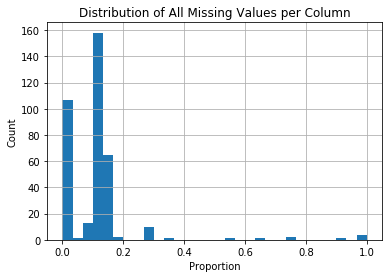

In [159]:
azdias_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

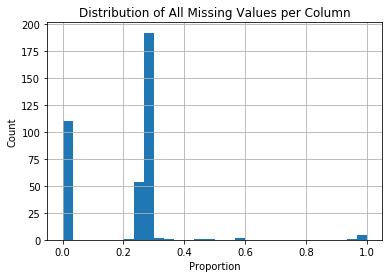

In [160]:
customers_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

In [161]:
#remove the features that has over 30% missing rate
remove_features=set(azdias_col_null[azdias_col_null>0.3].index)|set(customers_col_null[customers_col_null>0.3].index)
print(remove_features)
# azdias.drop(labels=remove_features,axis=1,inplace=True)
# customers.drop(labels=remove_features,axis=1,inplace=True)
# print(azdias.shape,customers.shape)
drop_features=drop_features|remove_features
print(drop_features)

{'REGIOTYP', 'KK_KUNDENTYP', 'KKK', 'AGER_TYP', 'EXTSEL992', 'ALTER_KIND3', 'ALTER_HH', 'ALTER_KIND4', 'TITEL_KZ', 'KBA05_BAUMAX', 'ALTER_KIND1', 'ALTER_KIND2'}
{'REGIOTYP', 'KK_KUNDENTYP', 'KKK', 'AGER_TYP', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'ALTER_KIND3', 'D19_LETZTER_KAUF_BRANCHE', 'ALTER_HH', 'CAMEO_DEU_2015', 'ALTER_KIND4', 'TITEL_KZ', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'EINGEFUEGT_AM', 'ALTER_KIND1', 'ALTER_KIND2'}


In [162]:
# redefine the categories_attribute and the numerical_attribute
categories_attribute=categories_attribute-drop_features
numerical_attribute=numerical_attribute-drop_features

In [163]:
my_azdias.drop(labels=drop_features,axis=1,inplace=True)
my_customers.drop(labels=drop_features,axis=1,inplace=True)

In [164]:
# deal with rows
azdias_row_null=(my_azdias.isnull().mean(axis=1)).sort_values(ascending=False)
customers_row_null=(my_customers.isnull().mean(axis=1)).sort_values(ascending=False)

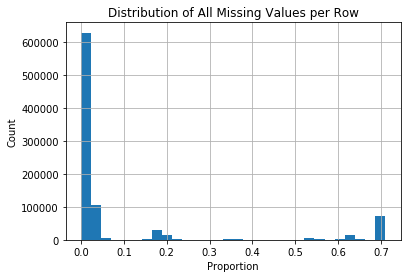

In [165]:
azdias_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

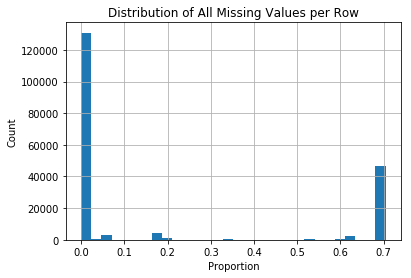

In [166]:
customers_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

In [167]:
print(my_azdias.shape,my_customers.shape)

(891221, 349) (191652, 352)


In [168]:
#remove the row that has over 10% missing rate
azdias_remove_row=azdias_row_null[azdias_row_null>0.1].index
customers_remove_row=customers_row_null[customers_row_null>0.1].index

my_azdias.drop(index=azdias_remove_row,axis=0,inplace=True)
my_customers.drop(index=customers_remove_row,axis=0,inplace=True)

In [169]:
print(my_azdias.shape,my_customers.shape)

(737215, 349) (134245, 352)


In [170]:
print(my_azdias.isnull().mean().mean())
print(my_customers.isnull().mean().mean())

0.007324992784837431
0.002320109264269196


In [171]:
# set index
my_azdias.set_index('LNR',inplace=True)
my_customers.set_index('LNR',inplace=True)

In [172]:
# dorp 3 attribute that only in my_customers dataset  
my_customers.drop(labels=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis=1,inplace=True)

In [181]:
# deal with the 'MIN_GEBAEUDEJAHR' , 'GEBURTSJAHR'
my_azdias['MIN_GEBAEUDEJAHR']=2018-my_azdias_customers['MIN_GEBAEUDEJAHR']
my_azdias['GEBURTSJAHR']=2018-my_azdias_customers['GEBURTSJAHR']

my_customers['MIN_GEBAEUDEJAHR']=2018-my_azdias_customers['MIN_GEBAEUDEJAHR']
my_customers['GEBURTSJAHR']=2018-my_azdias_customers['GEBURTSJAHR']

In [182]:
# fill the missing data in numerical_attribute
for l in numerical_attribute:
    my_azdias[l]=my_azdias[l].fillna(value=round(my_azdias['MIN_GEBAEUDEJAHR'].mean()))
    my_customers[l]=my_customers[l].fillna(value=round(my_customers['MIN_GEBAEUDEJAHR'].mean()))

In [183]:
len(my_azdias[list(numerical_attribute)].isnull().any()[my_azdias[list(numerical_attribute)].isnull().any()==True].index)

0

In [184]:
len(my_customers[list(numerical_attribute)].isnull().any()[my_customers[list(numerical_attribute)].isnull().any()==True].index)

0

In [186]:
# deal with the 'CAMEO_DEUG_2015',replace the X value by np.nan
my_azdias['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)
my_customers['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

In [187]:
my_azdias['CAMEO_DEUG_2015']=my_azdias['CAMEO_DEUG_2015'].astype('float')
my_customers['CAMEO_DEUG_2015']=my_customers['CAMEO_DEUG_2015'].astype('float')

In [188]:
attribute_value_number=[]
for i in categories_attribute:
    attribute_value_number.append((len(my_azdias[i].value_counts()),i))
print(sorted(attribute_value_number))

[(2, 'ANREDE_KZ'), (2, 'DSL_FLAG'), (2, 'GREEN_AVANTGARDE'), (2, 'HH_DELTA_FLAG'), (2, 'KBA05_SEG6'), (2, 'KONSUMZELLE'), (2, 'OST_WEST_KZ'), (2, 'SOHO_KZ'), (2, 'UNGLEICHENN_FLAG'), (2, 'VERS_TYP'), (3, 'HEALTH_TYP'), (3, 'KBA05_ANTG4'), (3, 'KBA05_KRSKLEIN'), (3, 'KBA05_KRSOBER'), (3, 'KBA05_KRSVAN'), (3, 'KBA05_KRSZUL'), (3, 'KBA05_MAXVORB'), (3, 'KBA13_ANTG4'), (3, 'KBA13_KMH_110'), (3, 'KBA13_KMH_251'), (3, 'KBA13_KW_30'), (3, 'NATIONALITAET_KZ'), (3, 'PLZ8_ANTG4'), (3, 'STRUKTURTYP'), (4, 'D19_TELKO_ONLINE_QUOTE_12'), (4, 'KBA05_ANHANG'), (4, 'KBA05_ANTG3'), (4, 'KBA05_MAXBJ'), (4, 'KBA05_MAXSEG'), (4, 'KBA05_MOD8'), (4, 'KBA05_MOTOR'), (4, 'KBA05_MOTRAD'), (4, 'KBA05_SEG1'), (4, 'KBA05_SEG7'), (4, 'KBA05_SEG8'), (4, 'KBA05_SEG9'), (4, 'KBA13_ANTG3'), (4, 'KBA13_KRSSEG_KLEIN'), (4, 'KBA13_KRSSEG_OBER'), (4, 'KBA13_KRSSEG_VAN'), (4, 'KBA13_KRSZUL_NEU'), (4, 'KBA13_MOTOR'), (4, 'PLZ8_ANTG3'), (4, 'SHOPPER_TYP'), (5, 'ALTERSKATEGORIE_GROB'), (5, 'CJT_KATALOGNUTZER'), (5, 'CJT_TYP_1'

In [86]:
%%time
my_azdias_customers[list(categories_attribute-set(['OST_WEST_KZ']))]=my_azdias_customers[list(categories_attribute-set(['OST_WEST_KZ']))].astype('float')

Wall time: 22.1 s


In [87]:
# To reduce the memory use of PCA, I choose almost categories to ordinal with DIAS_Attributes

In [88]:
%%time
my_azdias_customers_dummy=pd.get_dummies(data=my_azdias_customers[list(categories_attribute)])

Wall time: 4.39 s


In [89]:
print(my_azdias_customers_dummy.shape)

(871460, 340)


In [90]:
print(my_azdias_customers_dummy)

        KBA13_CCM_1800  KBA05_SEG3  KBA13_KW_70  HH_EINKOMMEN_SCORE  VHA  \
LNR                                                                        
910220             2.0         2.0          1.0                 6.0  0.0   
910225             4.0         3.0          4.0                 4.0  0.0   
910226             2.0         5.0          3.0                 1.0  1.0   
910241             3.0         1.0          2.0                 5.0  0.0   
910244             3.0         3.0          1.0                 5.0  0.0   
910248             3.0         3.0          1.0                 6.0  0.0   
910261             5.0         2.0          3.0                 4.0  0.0   
645145             3.0         5.0          2.0                 3.0  0.0   
645153             1.0         5.0          2.0                 4.0  0.0   
645165             1.0         4.0          0.0                 6.0  0.0   
612574             2.0         3.0          4.0                 5.0  0.0   
612586      

In [91]:
my_azdias_customers_df = pd.concat( [my_azdias_customers[list(numerical_attribute)], my_azdias_customers_dummy], axis=1 )

In [92]:
my_azdias_customers_df.shape

(871460, 349)

In [93]:
%%time
my_azdias_customers_df.to_pickle("my_azdias_customers_df.pkl")

Wall time: 8.33 s


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [94]:
%%time
if  'my_azdias_customers_df' in locals():
    pass
else:
    my_azdias_customers_df=pd.read_pickle("my_azdias_customers_df.pkl")

Wall time: 0 ns


In [95]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

In [96]:
my_azdias_customers_df.fillna(0,inplace=True)

In [161]:
# my_azdias_customers_df.iloc[my_customers_index.tolist()]
my_azdias_df=my_azdias_customers_df.iloc[my_azdias_index.tolist()]

IndexError: positional indexers are out-of-bounds

In [97]:
%%time
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(my_azdias_customers_df) 
scaled_df=pd.DataFrame(scaled, columns=my_azdias_customers_df.columns)

Wall time: 8.76 s


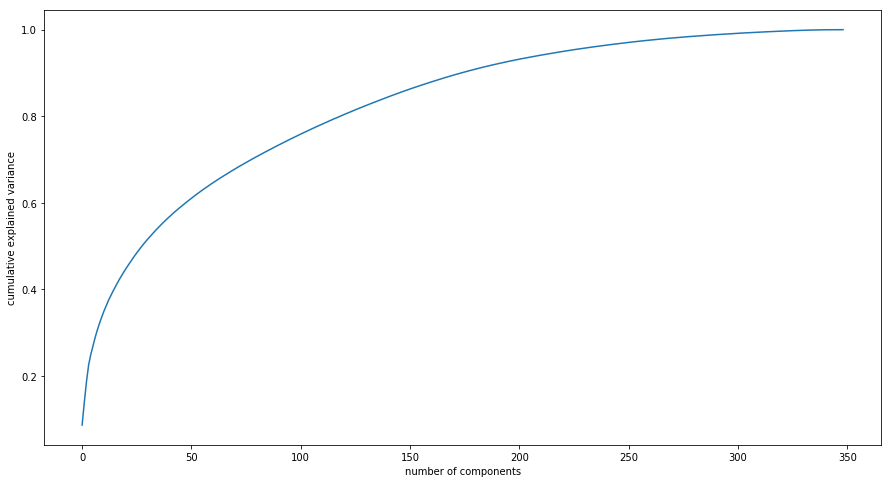

Wall time: 44.4 s


In [102]:
%%time
plt.figure(figsize=(15,8)) 
pca = PCA().fit(scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

<BarContainer object of 349 artists>

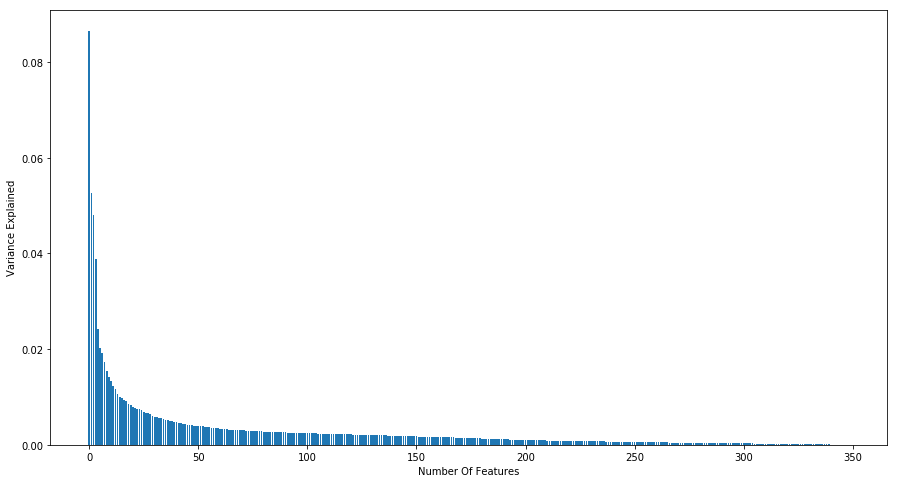

In [118]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(15,8)) 
explained_variance_ratio=[val for val in pca.explained_variance_ratio_]
cv=np.cumsum(np.round(explained_variance_ratio, decimals=3))
plt.ylabel('Variance Explained')
plt.xlabel('Number Of Features')
plt.bar(range(0,len(explained_variance_ratio)),explained_variance_ratio)

- I have done dimensionality reduction by getting explained ratio of principal components, As i observed 120 components/ eigen values were sufficient to explain more 80% variance in data so I opted that out. 

In [119]:
pca = PCA(n_components=120)
principalComponents_updated = pca.fit_transform(scaled)

In [140]:
type(principalComponents_updated)

numpy.ndarray

In [120]:
first_comp=pca.components_[0]
first_comp_sorted=sorted(first_comp,reverse=True)
first_comp_index=sorted(range(len(first_comp)), key=lambda k: first_comp[k])

In [121]:
cols_sorted=scaled_df.columns[first_comp_index]
positive_index=first_comp_index[:10]
negative_index=first_comp_index[-10:]
positive_cols=cols_sorted[:10]
negative_cols=cols_sorted[-10:]
positive_weights=first_comp_sorted[:10]
negative_weights=first_comp_sorted[-10:]
for i in range(10):
    print('Positive: ',positive_index[i],positive_cols[i],positive_weights[i],' Negative: ',negative_index[i],negative_cols[i],negative_weights[i])

Positive:  12 HH_EINKOMMEN_SCORE 0.13601605435103017  Negative:  110 FINANZ_MINIMALIST -0.10144786974111845
Positive:  253 PLZ8_ANTG3 0.12937291643527773  Negative:  213 KBA05_GBZ -0.10402332163885519
Positive:  56 KBA13_ANTG3 0.12715566402346767  Negative:  324 MOBI_RASTER -0.11936168676007489
Positive:  66 KBA13_BAUMAX 0.12701633292084355  Negative:  52 KBA05_AUTOQUOT -0.11959239775559499
Positive:  202 CAMEO_DEUG_2015 0.12619638875565956  Negative:  46 PLZ8_ANTG1 -0.12045558115860272
Positive:  65 KBA13_ANTG4 0.1253560465643636  Negative:  72 KBA13_ANTG1 -0.12058505773416486
Positive:  97 PLZ8_BAUMAX 0.12224721609602568  Negative:  204 KBA05_ANTG1 -0.12130081702630663
Positive:  98 PLZ8_ANTG4 0.1217254119222007  Negative:  18 LP_STATUS_GROB -0.12352082502752557
Positive:  94 VK_DISTANZ 0.11876479592924194  Negative:  128 LP_STATUS_FEIN -0.12392137599429165
Positive:  340 FINANZ_HAUSBAUER 0.11664054252342257  Negative:  189 MOBI_REGIO -0.126742375910422


In [122]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weightsOfPca(componentIndex):
    components=pca.components_[componentIndex]
    componentspd=pd.DataFrame(components,columns=['weight'])
    componentspd['name']=list(my_azdias_customers_df.columns)
    print(componentspd.sort_values(by='weight',ascending=False))

In [123]:
weightsOfPca(0)

       weight                       name
189  0.136016                 MOBI_REGIO
128  0.129373             LP_STATUS_FEIN
18   0.127156             LP_STATUS_GROB
204  0.127016                KBA05_ANTG1
72   0.126196                KBA13_ANTG1
46   0.125356                 PLZ8_ANTG1
52   0.122247             KBA05_AUTOQUOT
324  0.121725                MOBI_RASTER
213  0.118765                  KBA05_GBZ
110  0.116641          FINANZ_MINIMALIST
68   0.112059            KBA13_AUTOQUOTE
215  0.109139        LP_LEBENSPHASE_FEIN
283  0.101687        LP_LEBENSPHASE_GROB
146  0.095407                  KBA13_GBZ
251  0.093284          D19_GESAMT_ANZ_24
271  0.092377                   PLZ8_GBZ
182  0.090829               KBA05_ANHANG
299  0.090728                GEMEINDETYP
30   0.087561         D19_VERSAND_ANZ_24
302  0.086494          D19_GESAMT_ANZ_12
185  0.086321       KBA13_ALTERHALTER_60
2    0.086013               ANZ_PERSONEN
134  0.085518                KONSUMNAEHE
191  0.085350   

In [124]:
weightsOfPca(1)

       weight                         name
193  0.157500         KBA13_HERST_BMW_BENZ
262  0.135156               KBA13_MERCEDES
127  0.133303  KBA13_SEG_OBEREMITTELKLASSE
300  0.130511                    KBA13_BMW
206  0.123649                KBA13_SITZE_4
86   0.123323         KBA13_SEG_SPORTWAGEN
256  0.114257                 KBA05_HERST1
207  0.112906                KBA13_KMH_211
85   0.110920                KBA13_KMH_250
192  0.109653                 KBA13_KW_121
343  0.106447                    KBA05_KW3
240  0.106152         KBA13_SEG_OBERKLASSE
237  0.104209               KBA13_CCM_2501
116  0.100319      KBA13_KRSHERST_BMW_BENZ
264  0.096743               KBA13_CCM_3000
25   0.095980                  KBA05_MOTOR
151  0.094144                   KBA05_MOD1
344  0.092604              KBA13_HALTER_65
181  0.091977                   KBA05_CCM4
348  0.091968                OST_WEST_KZ_W
273  0.090431               KBA13_CCM_3001
71   0.089265             FINANZ_VORSORGER
250  0.0849

In [125]:
def pca_analysis(ind):
    first_comp=pca.components_[ind]
    first_comp_sorted=sorted(first_comp,reverse=True)
    first_comp_index=sorted(range(len(first_comp)), key=lambda k: first_comp[k])
    cols_sorted=scaled_df.columns[first_comp_index]
    positive_index=first_comp_index[:10]
    negative_index=first_comp_index[-10:]
    positive_cols=cols_sorted[:10]
    negative_cols=cols_sorted[-10:]
    positive_weights=first_comp_sorted[:10]
    negative_weights=first_comp_sorted[-10:]
    for i in range(10):
        print('Positive: ',positive_index[i],positive_cols[i],positive_weights[i],' Negative: ',negative_index[i],negative_cols[i],negative_weights[i])

In [126]:
pca_analysis(1)

Positive:  33 KBA13_SITZE_5 0.1575004913365811  Negative:  192 KBA13_KW_121 -0.09196752627009297
Positive:  303 KBA13_KMH_140_210 0.13515553313918688  Negative:  85 KBA13_KMH_250 -0.09248321309499503
Positive:  84 FINANZ_ANLEGER 0.1333034095087291  Negative:  207 KBA13_KMH_211 -0.09558855025852886
Positive:  55 KBA13_SEG_KLEINWAGEN 0.13051064098046616  Negative:  256 KBA05_HERST1 -0.09852922394638103
Positive:  318 KBA13_KMH_180 0.12364938372455153  Negative:  86 KBA13_SEG_SPORTWAGEN -0.10507108531821921
Positive:  234 KBA13_HALTER_25 0.12332333975420941  Negative:  206 KBA13_SITZE_4 -0.10805083655378014
Positive:  244 KBA13_KW_0_60 0.11425714211388048  Negative:  300 KBA13_BMW -0.11254636897471776
Positive:  339 KBA13_SEG_KOMPAKTKLASSE 0.1129056599412038  Negative:  127 KBA13_SEG_OBEREMITTELKLASSE -0.1128167376764313
Positive:  133 KBA13_HALTER_20 0.11091981229895771  Negative:  262 KBA13_MERCEDES -0.11442850924585242
Positive:  347 OST_WEST_KZ_O 0.10965312272552415  Negative:  193 KB

In [127]:
pca_analysis(2)

Positive:  27 D19_GESAMT_ONLINE_DATUM 0.1459509340944191  Negative:  118 CJT_TYP_1 -0.10574427719388738
Positive:  48 D19_VERSAND_ONLINE_DATUM 0.1370043965912984  Negative:  154 D19_VERSAND_ONLINE_QUOTE_12 -0.11342116180142268
Positive:  306 D19_GESAMT_DATUM 0.129716049796521  Negative:  194 D19_VERSAND_ANZ_12 -0.11450891816019308
Positive:  132 D19_VERSAND_DATUM 0.12660064569715726  Negative:  316 D19_GESAMT_ONLINE_QUOTE_12 -0.1160040759415515
Positive:  26 CJT_TYP_3 0.12606925812239078  Negative:  99 PRAEGENDE_JUGENDJAHRE -0.11615009579975284
Positive:  238 CJT_TYP_5 0.12593726297935443  Negative:  30 D19_VERSAND_ANZ_24 -0.12060841367008515
Positive:  57 CJT_TYP_6 0.11915417506184114  Negative:  21 CJT_TYP_2 -0.12423262452204939
Positive:  44 CJT_KATALOGNUTZER 0.11684845491378267  Negative:  302 D19_GESAMT_ANZ_12 -0.12606090406358658
Positive:  39 CJT_TYP_4 0.11596747537269694  Negative:  251 D19_GESAMT_ANZ_24 -0.1290605767202964
Positive:  156 VK_DHT4A 0.1157838359645995  Negative: 

In [133]:
%%time
kmeans_avg=[]
kmeans_res_li=[]
# Over a number of different cluster counts...
for ind in range(2,10):
    # run k-means clustering on the data and...
    print('For Cluster',ind,'Processing is going on')
    kmeans=KMeans(n_clusters=ind, random_state=0)
    res_kmeans=kmeans.fit_predict(principalComponents_updated)
    kmeans_res_li.append(res_kmeans)
    # compute the average within-cluster distances.
    kmeans_avg.append((kmeans.score(principalComponents_updated)/len(principalComponents_updated))*-1)

For Cluster 2 Processing is going on


KeyboardInterrupt: 

NameError: name 'avgdists' is not defined

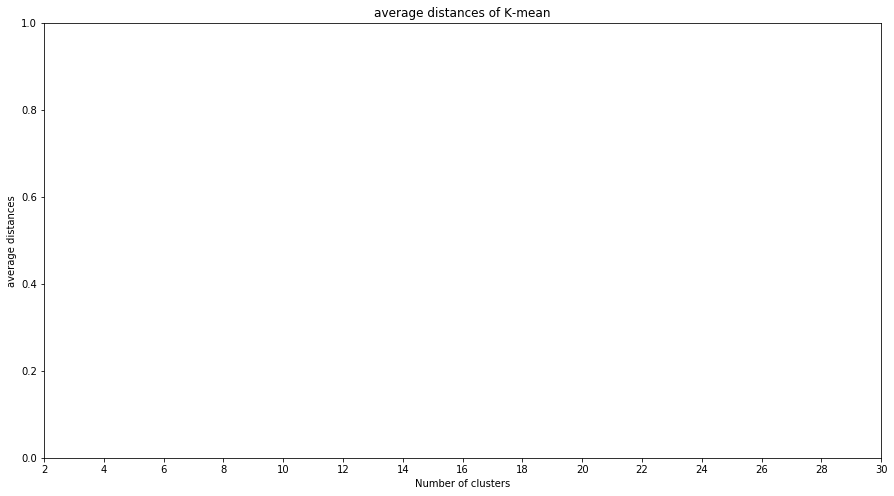

In [134]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(15,8)) 
plt.title('average distances of K-mean')
plt.xlabel('Number of clusters')
plt.ylabel('average distances')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28],[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30])
plt.plot(avgdists,marker='o')

In [130]:
print(kmeans_avg)

[257.2162628316273, 247.61131779725787, 241.41867210053198, 236.42086584695946, 232.3060948168987, 229.04852315731367, 226.5262459245744, 224.11702674319199]


- I think 18 is the best.

In [135]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans=KMeans(n_clusters=18, random_state=0)
res_kmeans_18=kmeans.fit_predict(principalComponents_updated)

In [137]:
print(res_kmeans_18)

[ 3  3  2 ... 17 13  5]


In [138]:
res_kmeans_18_azdias=res_kmeans_18

In [139]:
len(res_kmeans_18)

871460

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [45]:
mailout_train = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

FileNotFoundError: File b'../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv' does not exist

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')